In [87]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [88]:
import pandas as pd

In [89]:
torch_version = str(torch.__version__)
print(f'torch version: {torch_version}')

scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
%pip install torch-scatter -f $scatter_src
%pip install torch-sparse -f $sparse_src
%pip install torch-geometric
%pip install ogb

torch version: 2.1.0+cu121
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html


## load data

In [90]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cpu


In [92]:
MOVIE_HEADERS = [
    "movieId", "title", "releaseDate", "videoReleaseDate", "IMDb URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
USER_HEADERS = ["userId", "age", "gender", "occupation", "zipCode"]
RATING_HEADERS = ["userId", "movieId", "rating", "timestamp"]


data_path = '/content/drive/MyDrive/CS247/Project/ColdGAN/ml-100k/'

# Process user data:
df_user = pd.read_csv(
    #Path to user data goes here
    data_path + 'u.user',
    sep='|',
    header=None,
    names=USER_HEADERS,
    index_col='userId',
    encoding='ISO-8859-1',
)


# Process rating data for training:
df_rating_train = pd.read_csv(
    data_path + 'u1.base',
    sep='\t',
    header=None,
    index_col='userId',
    names=RATING_HEADERS,
).reset_index()

# Process rating data for testing:
df_rating_test = pd.read_csv(
    data_path + 'u1.test',
    sep='\t',
    header=None,
    index_col='userId',
    names=RATING_HEADERS,
).reset_index()

#Combine user and rating data into one vector

# df_train = df_user.copy().merge(df_rating_train, how='right', left_on='userId', right_on='userId')

# df_test = df_user.copy().merge(df_rating_test, how='right', left_on='userId', right_on='userId')
# rating = torch.from_numpy(df_rating_train['rating'].values).to(torch.long)


In [93]:
user_mapping = {idx: i for i, idx in enumerate(df_user.index)}

age = df_user['age'].values / df_user['age'].values.max()
age = torch.from_numpy(age).to(torch.float).view(-1, 1)

gender = df_user['gender'].str.get_dummies().values
gender = torch.from_numpy(gender).to(torch.float)

occupation = df_user['occupation'].str.get_dummies().values
occupation = torch.from_numpy(occupation).to(torch.float)

zipcode = df_user['zipCode'].str.get_dummies().values
zipcode = torch.from_numpy(zipcode).to(torch.float)

users = torch.cat([age, gender, occupation, zipcode], dim=-1).to(device)

In [94]:
ratings = []
timestamps = []
num_movies = 1682
for user in user_mapping:
  user_ratings_df = df_rating_train.loc[df_rating_train['userId'] == user].sort_values('timestamp')
  user_ratings = torch.zeros((num_movies,), dtype=torch.float)
  user_timestamps = torch.zeros((num_movies,), dtype=torch.float)
  for i, (index, row) in enumerate(user_ratings_df.iterrows()):
    user_ratings[row['movieId']-1] = row['rating']
    user_timestamps[row['movieId']-1] = i + 1



  ratings.append(user_ratings)
  timestamps.append(user_timestamps)

ratings = torch.from_numpy(np.array(ratings)).to(device)
timestamps = torch.from_numpy(np.array(timestamps))

In [95]:
ratings_test = []
timestamps_test = []
num_movies = 1682
for user in user_mapping:
  user_ratings_df = df_rating_test.loc[df_rating_test['userId'] == user].sort_values('timestamp')
  user_ratings_test = torch.zeros((num_movies,), dtype=torch.float)
  user_timestamps_test = torch.zeros((num_movies,), dtype=torch.float)
  for i, (index, row) in enumerate(user_ratings_df.iterrows()):
    user_ratings_test[row['movieId']-1] = row['rating']
    user_timestamps_test[row['movieId']-1] = i + 1



  ratings_test.append(user_ratings_test)
  timestamps_test.append(user_timestamps_test)

ratings_test = torch.from_numpy(np.array(ratings_test)).to(device)
timestamps_test = torch.from_numpy(np.array(timestamps_test))

In [96]:
movie_popularity = df_rating_train['movieId'].value_counts().sort_index()
movie_popularity = movie_popularity.reindex(list(range(1,num_movies+1)),fill_value=0).values
movie_popularity = torch.from_numpy(movie_popularity / np.max(movie_popularity)).to(device)

In [97]:
print(movie_popularity)

tensor([0.7913, 0.2169, 0.1550,  ..., 0.0021, 0.0021, 0.0021],
       dtype=torch.float64)


In [98]:
print(len(ratings))

943


In [99]:
print(len(users))

943


In [100]:
len(movie_popularity)

1682

In [101]:
from torch.utils.data import Dataset, DataLoader


class RatingsDataset(Dataset):
    def __init__(self, users, ratings, timestamps):
        self.len = len(users)
        self.users = users
        self.ratings = ratings
        self.timestamps = timestamps

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        user_vec = self.users[idx]
        ratings_vec = self.ratings[idx]
        timestamps_vec = self.timestamps[idx]

        return user_vec, ratings_vec, timestamps_vec

    @staticmethod
    def collate_fn(data):
        user_vec = torch.stack([_[0] for _ in data], dim=0)
        ratings_vec = torch.stack([_[1] for _ in data], dim=0)
        timestamps_vec = torch.stack([_[2] for _ in data], dim=0)
        return user_vec, ratings_vec, timestamps_vec

In [102]:
batch_size = 41
dataset = RatingsDataset(users, ratings, timestamps)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=RatingsDataset.collate_fn)

In [103]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 41

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.4


## helper functions

In [104]:

# Get batch data from training set
def get_batch_data(file, index, size):  # 1,5->1,2,3,4,5
    user = []
    item = []
    label = []
    for i in range(index, index + size):
        line = linecache.getline(file, i)
        line = line.strip()
        line = line.split()
        user.append(int(line[0]))
        user.append(int(line[0]))
        item.append(int(line[1]))
        item.append(int(line[2]))
        label.append(1.)
        label.append(0.)
    return user, item, label

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


# Get category of items
def get_category(file_in):
    category = {}
    #with open(file_in) as fin:
    with open(file_in,encoding='unicode_escape') as fin:
        for line in fin:
            line = line.split('|')
            iid = int(line[0]) - 1  # item id starts from 0
            category[iid] = line[6:24]
    return category


# Get training/testing data
def get_train_test_data(file_in):
    # only record user-item pairs with rating >=4
    user_item = {}
    with open(file_in) as fin:
        for line in fin:
            line = line.split()
            uid = int(line[0])
            iid = int(line[1])
            r = float(line[2])
            if uid in user_item:
                user_item[uid].append(iid)
            else:
                user_item[uid] = [iid]
    return user_item


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        # if method == 0:
        #     return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        # else:
        #     raise ValueError('method must be 0 or 1.')
    else:
        return 0.


def ndcg_at_k(r, k):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max


def recall_at_k(r, k, all_pos_num):
    r = np.asfarray(r)[:k]
    return np.sum(r) / all_pos_num


def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.


def diversity_by_category(selected_items, item_cate, cate_num):
    cate = []
    for iid in selected_items:
        try:
            cate.append(item_cate[iid])
        except KeyError:
            pass

    cate_count = np.count_nonzero(np.sum(np.asarray(cate, np.float32), axis=0))

    return cate_count/cate_num


def get_div_train_data(file_in):
    user_train_samples = {}

    with open(file_in) as fin:
        for line in fin:
            line = line.split('\t')
            uid = int(line[0])
            items = list(map(int, line[1:]))
            if uid in user_train_samples:
                user_train_samples[uid].append(items)
            else:
                user_train_samples[uid] = [items]

    return user_train_samples


def generate_pairwise_diversity_training_data(file_train, file_cate, file_out_pos, file_out_neg, user_num):
    pos_data = []  # data for output
    neg_data = []

    #########################################################################################
    # Load data
    #########################################################################################
    category = get_category(file_cate)
    user_item = get_train_test_data(file_train)

    # for each user, generate diversity set
    for i in range(0, user_num):
        uid = i;
        print('user:', uid)
        try:
            items = user_item[uid]
        except KeyError:
            pass
        # the number of trials for each user is set to be the number of viewed items
        for j in range(0, len(items)):
            first_item = items[j]
            pos_div_set = [first_item]  # make sure each viewed item is sampled
            pos_cate = [category[first_item]]
            num_cate = np.count_nonzero(np.sum(np.asarray(pos_cate, np.float32), axis=0))
            # the number of trials for each diversity set is the number of viewed items
            for k in range(0, len(items)):
                new_item = np.random.choice(items)
                try:
                    pos_cate.append(category[new_item])
                    new_num_cate = np.count_nonzero(np.sum(np.asarray(pos_cate, np.float32), axis=0))
                    if new_num_cate - num_cate > 0:
                        pos_div_set.append(new_item)
                        num_cate = new_num_cate
                    if len(pos_div_set) == 10:
                        break;
                except KeyError:
                    pass

            pos_div_set.sort()
            pos_data.append(str(uid) + '\t' + '\t'.join(str(x) for x in pos_div_set))

            neg_div_set = [first_item]  # make sure each viewed item is sampled
            neg_cate = np.asarray(category[first_item], np.int32).nonzero()[0]
            # the number of trials for each diversity set is the number of viewed items
            for k in range(0, len(items)):
                new_item = items[k]
                try:
                    if new_item not in neg_div_set:
                        new_cate = np.asarray(category[new_item], np.int32).nonzero()[0]
                        if np.array_equal(neg_cate, new_cate):
                            neg_div_set = np.append(neg_div_set, new_item)
                            if len(neg_div_set) > 10:  # due to tensorflow bug
                                neg_div_set = np.random.choice(neg_div_set, 10, replace=False)
                except KeyError:
                    pass
            neg_div_set.sort()
            neg_data.append(str(uid) + '\t' + '\t'.join(str(x) for x in neg_div_set))

    with open(file_out_pos, 'w')as fout:
        fout.write('\n'.join(pos_data))

    with open(file_out_neg, 'w')as fout:
        fout.write('\n'.join(neg_data))


In [105]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## generator

In [328]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.first_linear = nn.Sequential(
            #Input shape of (batch_size, num_movies)
            nn.Linear(num_movies, 1024),
            nn.ReLU(),
        )
        self.main = nn.Sequential(
            #Input shape of (batch_size, 1, 1024)
            nn.Conv1d(1, 3, 8, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(3),
            nn.Dropout(0.05),
            #Input shape of (batch_size, 3, 509)

            nn.Conv1d(3, 9, 9, stride=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(9),
            nn.Dropout(0.05),

            #Input shape of (batch_size, 9, 101)
            nn.ConvTranspose1d(9, 3, 9, stride=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(3),
            nn.Dropout(0.1),

            #Input shape of (batch_size, 3, 509)
            nn.ConvTranspose1d(3, 1, 8, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
            nn.Dropout(0.1),
        )
        self.last_linear = nn.Sequential(
            #Input shape of (batch_size, num_movies)
            nn.Linear(1024, num_movies),
            nn.ReLU(),
        )


    def forward(self, user_vec, rating_vec):
        rating_vec = rating_vec.view(-1, 1, num_movies)
        out = self.first_linear(rating_vec)
        out = self.main(out)
        out = self.last_linear(out).view(-1, num_movies)
        return out

In [329]:
ngpu = 1

## discriminator

In [373]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(num_movies, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1),
            nn.Dropout(0.7),
            #Input shape of (batch_size, 1, 1024)
            nn.Conv1d(1, 2, 4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2),
            nn.Dropout(0.7),
            #Input shape of (batch_size, 2, 511)

            nn.Conv1d(2, 4, 6, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.7),

            #Input shape of (batch_size, 4, 254)
            nn.Conv1d(4, 8, 4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(8),
            nn.Dropout(0.6),

            #Input shape of (batch_size, 8, 126)
            nn.Conv1d(8, 1, 2, stride=4),
            #(batch_size, 1, 32)
            nn.Linear(31, 1),
            nn.Sigmoid()
        )


    def forward(self, user_vec, rating_vec):
        rating_vec = rating_vec.view(-1, 1, num_movies)
        return self.main(rating_vec)

In [364]:
#Generate cold state from warm state
p_min = 0.0
p_max = 0.85
alpha = 4
def rejuvenation_function(rating_vector, timestamp_vector, alpha, p_min, p_max):
  #Need time + popularity of item rating
  #For tth item, probability of choosing in cold state is
  #pm(t) = p_min + (p_max - p_min) * exp(-alpha * [t - pop(i_t)]/ [count(wm)])
  count = torch.count_nonzero(rating_vector)
  t_vector = timestamp_vector.to(device)
  # cpu index is -1
  prob_vector = p_min + (p_max - p_min) * torch.exp(-alpha * (t_vector - movie_popularity)/ count)
  random_selection = torch.from_numpy(np.random.rand(num_movies)).to(device) < prob_vector
  return rating_vector * random_selection

In [365]:
warm_vector = ratings[0]
cold_vector = rejuvenation_function(ratings[0], timestamps[0], alpha, p_min, p_max)
for i in range(num_movies):
  if warm_vector[i] != cold_vector[i]:
    print(warm_vector[i])
    print(cold_vector[i])

tensor(5.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(3.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(4.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(4.)

In [366]:
import torch.nn.functional as F

## relevant loss function

In [367]:
import torch.nn.functional as F
class RelevantLoss(nn.Module):
  def init(self):
    super(RelevantLoss, self).init()

  def forward(self, rating_vector, actual_warm):
    #Sum of binary cross-entropy loss b/w sigmoid gan out and wrel
    #divided by number items rated by user
    n_m = torch.count_nonzero(actual_warm, axis=1).view(-1, 1)
    avg_rating = torch.sum(actual_warm, axis=1).view(-1, 1) / n_m
    relevance_vector = (actual_warm > avg_rating).float()
    activation_vector = (actual_warm > 0).float()
    bce_loss = torch.sum(F.binary_cross_entropy(F.sigmoid(rating_vector) * activation_vector, relevance_vector, reduction='none') / (avg_rating * num_movies) )

    return bce_loss
rel_loss = RelevantLoss()

In [368]:
rel_loss = RelevantLoss()

In [369]:
torch.use_deterministic_algorithms(False)

In [370]:
for i in dataloader:
  cold = rejuvenation_function(i[1], i[2], alpha, p_min, p_max)
  print(rel_loss(cold, i[1]))
  break

tensor(0.5802)


In [375]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
# if (device == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the ``weights_init`` function to randomly initialize all weights
# #  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (first_linear): Sequential(
    (0): Linear(in_features=1682, out_features=1024, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): Conv1d(1, 3, kernel_size=(8,), stride=(2,))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Conv1d(3, 9, kernel_size=(9,), stride=(5,))
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): ConvTranspose1d(9, 3, kernel_size=(9,), stride=(5,))
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.1, inplace=Fa

In [374]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
# if (device == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# # Apply the ``weights_init`` function to randomly initialize all weights
# # like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=1682, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Conv1d(1, 2, kernel_size=(4,), stride=(2,))
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.7, inplace=False)
    (8): Conv1d(2, 4, kernel_size=(6,), stride=(2,))
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.7, inplace=False)
    (12): Conv1d(4, 8, kernel_size=(4,), stride=(2,))
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.6, inplace=False)
    (16): Conv1d(8, 1, kernel_size=(2,), stride=(4,))
    (17): Linear(in_features=31, out_features=1, bias=True)
    (18): Si

In [376]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [377]:
num_epochs=150

## training loop

In [ ]:
# Training Loop
netG.train()
netD.train()
# Lists to keep track of progress
fake_warm = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
print(dataloader)

netD.train()
netG.train()
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        user_vecs = data[0]
        ratings_vecs = data[1]
        timestamps_vecs = data[2]
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        b_size = user_vecs.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(user_vecs, ratings_vecs).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        cold_vectors = rejuvenation_function(ratings_vecs, timestamps_vecs, alpha, p_min, p_max)
        # Generate fake image batch with G
        fake  = netG(user_vecs, cold_vectors)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(user_vecs, fake).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        #Generate fakes again
        # fake  = netG(user_vecs, cold_vectors)
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(user_vecs, fake).view(-1)
        # Calculate G's loss based on this output
        # rel_loss = 0#relevant_loss(fake, ratings_vecs).sum() / np.count_nonzero(ratings_vecs)
        errG_D = criterion(output, label)
        errG_R = rel_loss(fake, ratings_vecs)
        # Calculate gradients for G
        errG_D.backward(retain_graph=True)
        errG_R.backward()
        errG = errG_D + errG_R
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            #Get random cold vector
            idx = np.random.randint(len(users), size=2)
            noise_user = users[idx]
            fixed_noise = rejuvenation_function(ratings[idx], timestamps[idx], alpha=0.1, p_min=0, p_max=0.85)
            with torch.no_grad():
                fake = netG(noise_user, fixed_noise)
            fake_warm.append((fake, idx))

        iters += 1

Starting Training Loop...
[0/150][0/23]	Loss_D: 1.3022	Loss_G: 1.0852	D(x): 0.5637	D(G(z)): 0.4946 / 0.5199
[1/150][0/23]	Loss_D: 1.1735	Loss_G: 1.4623	D(x): 0.5585	D(G(z)): 0.4194 / 0.4045
[2/150][0/23]	Loss_D: 1.1819	Loss_G: 1.2020	D(x): 0.5894	D(G(z)): 0.4548 / 0.4786
[3/150][0/23]	Loss_D: 1.2470	Loss_G: 1.3547	D(x): 0.5722	D(G(z)): 0.4724 / 0.4577
[4/150][0/23]	Loss_D: 1.4376	Loss_G: 1.2298	D(x): 0.5399	D(G(z)): 0.5394 / 0.5063
[5/150][0/23]	Loss_D: 1.3298	Loss_G: 1.1754	D(x): 0.5270	D(G(z)): 0.4731 / 0.4957
[6/150][0/23]	Loss_D: 1.3852	Loss_G: 1.2540	D(x): 0.5154	D(G(z)): 0.4886 / 0.4507
[7/150][0/23]	Loss_D: 1.3983	Loss_G: 1.4848	D(x): 0.5055	D(G(z)): 0.4758 / 0.4482
[8/150][0/23]	Loss_D: 1.3719	Loss_G: 1.1661	D(x): 0.5233	D(G(z)): 0.4934 / 0.4996
[9/150][0/23]	Loss_D: 1.3127	Loss_G: 1.2114	D(x): 0.5438	D(G(z)): 0.4887 / 0.4551
[10/150][0/23]	Loss_D: 1.3384	Loss_G: 1.0737	D(x): 0.5119	D(G(z)): 0.4685 / 0.4793
[11/150][0/23]	Loss_D: 1.2961	Loss_G: 1.1726	D(x): 0.5225	D(G(z)): 0.46

In [ ]:
# torch.save(netG.state_dict(), "/content/drive/MyDrive/CS247/Project/ColdGAN/gen.pth")

In [ ]:
# torch.save(netD.state_dict(), "/content/drive/MyDrive/CS247/Project/ColdGAN/dis.pth")

## generate fake user data

In [ ]:
netG.eval()
threshold = torch.tensor(0)
with open("/content/drive/MyDrive/CS247/Project/ColdGAN/gan_ratings.dat", "w") as f:
  for user_1, user_2 in zip(list(user_mapping.values())[::2], list(user_mapping.values())[1::2]):
    user_pair = torch.tensor([user_1, user_2])
    random_cold_vector = rejuvenation_function(ratings[user_pair], timestamps[user_pair], alpha=alpha, p_min=p_min, p_max=p_max)
    fake_warm = netG(users[user_pair], random_cold_vector)
    with torch.no_grad():
      for movie_id, rate in enumerate(fake_warm[0]):
        flag = (rate.item() >= threshold).item() and (ratings[user_1] == 0)[movie_id]
        if flag:
          f.write(str(user_1+1) + " " + str(movie_id+1) + " " + str(rate.item()) + "\n")
      for movie_id, rate in enumerate(fake_warm[1]):
        flag = (rate.item() >= threshold).item() and (ratings[user_2] == 0)[movie_id]
        if flag:
          f.write(str(user_2+1) + " " + str(movie_id+1) + " " + str(rate.item()) + "\n")

In [144]:
netG.eval()

Generator(
  (first_linear): Sequential(
    (0): Linear(in_features=1682, out_features=1024, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): Conv1d(1, 3, kernel_size=(8,), stride=(2,))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv1d(3, 9, kernel_size=(9,), stride=(5,))
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): ConvTranspose1d(9, 3, kernel_size=(9,), stride=(5,))
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): ConvTranspose1d(3, 1, kernel_size=(8,), stride=(2,))
    (13): ReLU(inplace=True)
    (14): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.25, inplace=

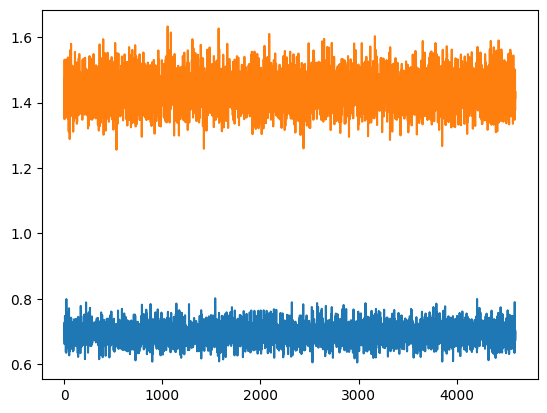

In [142]:
import matplotlib.pyplot as plt

plt.plot(G_losses)
plt.plot(D_losses)

In [16]:
ngpu=1
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
netG.load_state_dict(torch.load('/content/drive/MyDrive/CS247/Project/ColdGAN/gen.pth'))
netD.load_state_dict(torch.load('/content/drive/MyDrive/CS247/Project/ColdGAN/dis.pth'))

<All keys matched successfully>

In [145]:
#Generate predictions
criterion = torch.nn.MSELoss(reduction='mean')
losses = []
netG.eval()
for user_1, user_2 in zip(list(user_mapping.values())[::2], list(user_mapping.values())[1::2]):
    user_pair = torch.tensor([user_1, user_2])
    random_cold_vector = rejuvenation_function(ratings[user_pair], timestamps[user_pair], alpha=4, p_min=0, p_max=0.85)
    with torch.no_grad():
      fake_warm = netG(users[user_pair], random_cold_vector)
      actual_warm = ratings_test[user_pair]
      activation_vector = actual_warm[0] > 0
      if torch.count_nonzero(actual_warm[0]) > 0:
        loss = torch.sqrt(criterion(fake_warm[0] * activation_vector, actual_warm[0] ))
        print(loss.item())
        print(torch.count_nonzero(actual_warm[0]))
        print(torch.count_nonzero(fake_warm[0] * activation_vector))
        losses.append(loss)
      activation_vector = actual_warm[1] > 0
      if torch.count_nonzero(actual_warm[1]) > 0:
        loss = torch.sqrt(criterion(fake_warm[1] * activation_vector, actual_warm[1]))
        print(loss.item())
        print(torch.count_nonzero(actual_warm[1]))
        print(torch.count_nonzero(fake_warm[1] * activation_vector))
        losses.append(loss)



1.0348666906356812
tensor(137)
tensor(65)
0.4134764075279236
tensor(22)
tensor(8)
0.33827030658721924
tensor(26)
tensor(16)
0.3213072419166565
tensor(10)
tensor(6)
0.6615376472473145
tensor(84)
tensor(41)
0.9120976328849792
tensor(101)
tensor(54)
1.318834900856018
tensor(190)
tensor(88)
0.5252973437309265
tensor(29)
tensor(21)
0.33669623732566833
tensor(10)
tensor(5)
0.9490993618965149
tensor(90)
tensor(43)
0.7060447931289673
tensor(76)
tensor(41)
0.5535240769386292
tensor(26)
tensor(11)
1.2086725234985352
tensor(263)
tensor(137)
0.7354251146316528
tensor(57)
tensor(30)
0.4587061405181885
tensor(44)
tensor(23)
0.8924480080604553
tensor(71)
tensor(32)
0.20790833234786987
tensor(9)
tensor(4)
0.9853704571723938
tensor(118)
tensor(59)
0.25935274362564087
tensor(10)
tensor(5)
0.3315555453300476
tensor(22)
tensor(14)
0.6457411050796509
tensor(84)
tensor(42)
0.6762939691543579
tensor(58)
tensor(30)
0.7098115086555481
tensor(63)
tensor(31)
0.5304799675941467
tensor(27)
tensor(10)
0.59192574024

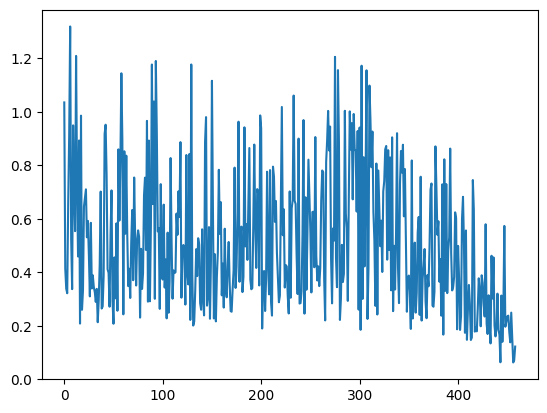

In [146]:
import matplotlib.pyplot as plt
plt.plot(losses)


In [133]:
losses_without_sparse = []
for user_1, user_2 in zip(list(user_mapping.values())[::2], list(user_mapping.values())[1::2]):
    user_pair = torch.tensor([user_1, user_2])
    random_cold_vector = rejuvenation_function(ratings[user_pair], timestamps[user_pair], alpha=4, p_min=0, p_max=0.85)
    with torch.no_grad():
      fake_warm = netG(users[user_pair], random_cold_vector)
      actual_warm = ratings_test[user_pair]
      activation_vector = (actual_warm[0] > 0)
      if torch.count_nonzero(actual_warm[0]) > 0:
        loss = torch.sqrt(criterion(fake_warm[0] * activation_vector, actual_warm[0] * (fake_warm[0] > 0)) / torch.count_nonzero(actual_warm[0]))
        print(loss)
        losses_without_sparse.append(loss)
      activation_vector = (actual_warm[1] > 0)
      if torch.count_nonzero(actual_warm[1]) > 0:
        loss = torch.sqrt(criterion(fake_warm[1] * activation_vector, actual_warm[1] * (fake_warm[1] > 0)) / torch.count_nonzero(actual_warm[1]))
        print(loss)
        losses_without_sparse.append(loss)


tensor(2.1962)
tensor(2.2383)
tensor(1.4331)
tensor(2.4257)
tensor(1.8743)
tensor(2.4656)
tensor(2.5781)
tensor(2.8726)
tensor(2.4286)
tensor(2.6615)
tensor(2.1325)
tensor(2.6301)
tensor(2.0123)
tensor(2.7461)
tensor(2.0269)
tensor(2.5586)
tensor(1.1497)
tensor(2.2071)
tensor(2.8875)
tensor(1.8869)
tensor(1.8478)
tensor(2.2960)
tensor(2.6231)
tensor(2.9742)
tensor(2.7034)
tensor(2.0946)
tensor(1.7998)
tensor(2.3908)
tensor(2.4787)
tensor(2.5211)
tensor(2.5853)
tensor(1.6478)
tensor(1.9005)
tensor(2.3742)
tensor(2.4754)
tensor(2.6601)
tensor(2.6691)
tensor(2.6178)
tensor(2.3688)
tensor(1.9417)
tensor(2.5803)
tensor(2.4631)
tensor(2.3117)
tensor(2.4556)
tensor(1.8085)
tensor(2.4939)
tensor(2.5578)
tensor(2.5061)
tensor(1.8159)
tensor(2.6812)
tensor(1.0654)
tensor(2.6071)
tensor(2.7501)
tensor(2.0124)
tensor(3.0072)
tensor(2.3218)
tensor(2.2403)
tensor(2.5790)
tensor(2.3870)
tensor(2.6252)
tensor(2.5455)
tensor(1.8265)
tensor(1.8776)
tensor(2.2936)
tensor(2.3913)
tensor(2.0114)
tensor(2.4

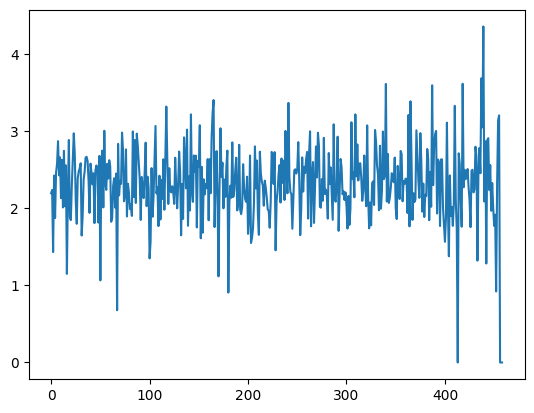

In [134]:
plt.plot(losses_without_sparse)


In [135]:
criterion(torch.tensor(losses_without_sparse), torch.tensor(losses)) / len(losses)

tensor(1.6923)

In [136]:
losses_without_filter = []
for user_1, user_2 in zip(list(user_mapping.values())[::2], list(user_mapping.values())[1::2]):
    user_pair = torch.tensor([user_1, user_2])
    random_cold_vector = rejuvenation_function(ratings[user_pair], timestamps[user_pair], alpha=4, p_min=0, p_max=0.85)
    with torch.no_grad():
      fake_warm = netG(users[user_pair], random_cold_vector)
      actual_warm = ratings_test[user_pair]
      activation_vector = actual_warm[0] > 0
      if torch.count_nonzero(actual_warm[0]) > 0:
        loss = torch.sqrt(criterion(fake_warm[0], actual_warm[0]))
        print(loss)
        losses_without_filter.append(loss)
      activation_vector = actual_warm[1] > 0
      if torch.count_nonzero(actual_warm[1]) > 0:
        loss = torch.sqrt(criterion(fake_warm[1], actual_warm[1]))
        print(loss)
        losses_without_filter.append(loss)


tensor(46.3521)
tensor(22.3926)
tensor(18.2808)
tensor(27.5753)
tensor(33.1075)
tensor(40.0012)
tensor(58.7792)
tensor(23.5287)
tensor(20.0081)
tensor(44.1080)
tensor(34.1594)
tensor(29.5582)
tensor(55.1819)
tensor(32.1719)
tensor(23.2948)
tensor(41.2024)
tensor(14.9850)
tensor(46.0233)
tensor(19.4674)
tensor(25.8487)
tensor(32.1534)
tensor(33.7957)
tensor(35.5890)
tensor(28.0407)
tensor(30.8395)
tensor(25.4032)
tensor(21.2385)
tensor(31.0481)
tensor(20.3358)
tensor(27.0323)
tensor(25.8432)
tensor(21.1548)
tensor(20.0230)
tensor(23.6535)
tensor(25.8661)
tensor(17.2946)
tensor(25.6281)
tensor(34.7855)
tensor(23.5526)
tensor(21.5125)
tensor(20.3919)
tensor(41.5303)
tensor(43.5439)
tensor(34.2578)
tensor(24.0825)
tensor(25.9056)
tensor(25.3157)
tensor(26.1709)
tensor(33.3699)
tensor(22.3011)
tensor(17.5162)
tensor(29.1979)
tensor(22.8990)
tensor(29.8567)
tensor(16.2862)
tensor(41.8819)
tensor(28.2687)
tensor(38.5000)
tensor(50.9188)
tensor(42.2877)
tensor(18.1926)
tensor(40.7206)
tensor(2

In [137]:
criterion(torch.tensor(losses_without_filter), torch.tensor(losses))

tensor(322734.5000)

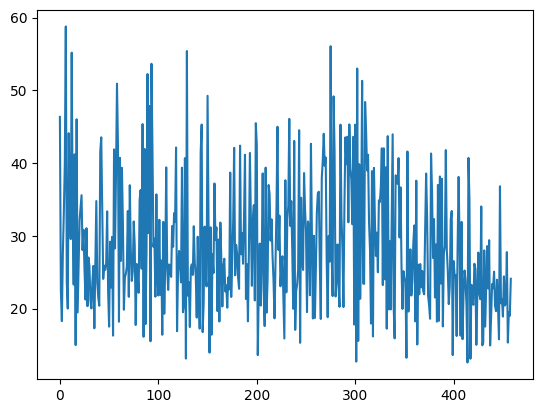

In [138]:
plt.plot(losses_without_filter)
